In [ ]:
!pip install pykalman

In [ ]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow keras hmmlearn statsmodels ta transformers torch tqdm

In [1]:
%pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import BayesianGaussianMixture
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


c:\Users\viswa\GithubClonedRepos\PAML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[*********************100%***********************]  1 of 1 completed


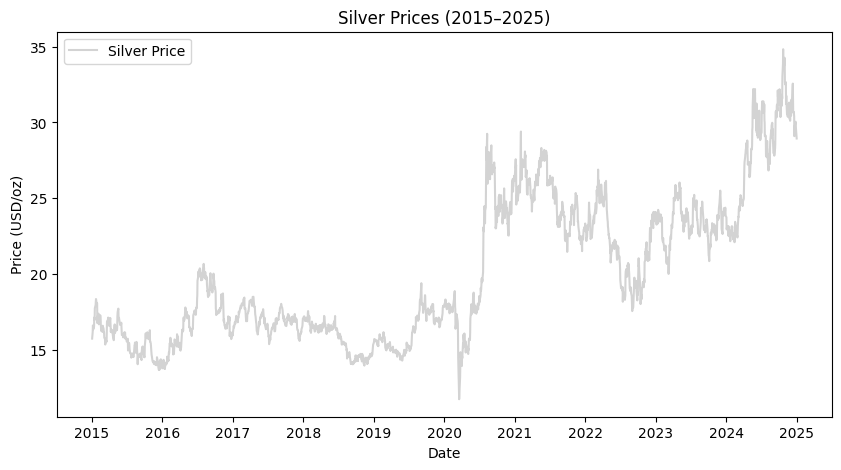

Price,SILVER
Ticker,SI=F
Date,
2015-01-02,15.734000
2015-01-05,16.179001
2015-01-06,16.603001
2015-01-07,16.510000
2015-01-08,16.351000


In [2]:
# --- Load Silver Prices ---
df = yf.download("SI=F", start="2015-01-01", end="2025-01-01")  # COMEX Silver Futures
df = df[["Close"]].rename(columns={"Close": "SILVER"})
df.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df["SILVER"], label="Silver Price", color='lightgray')
plt.title("Silver Prices (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD/oz)")
plt.legend()
plt.show()

df.head()

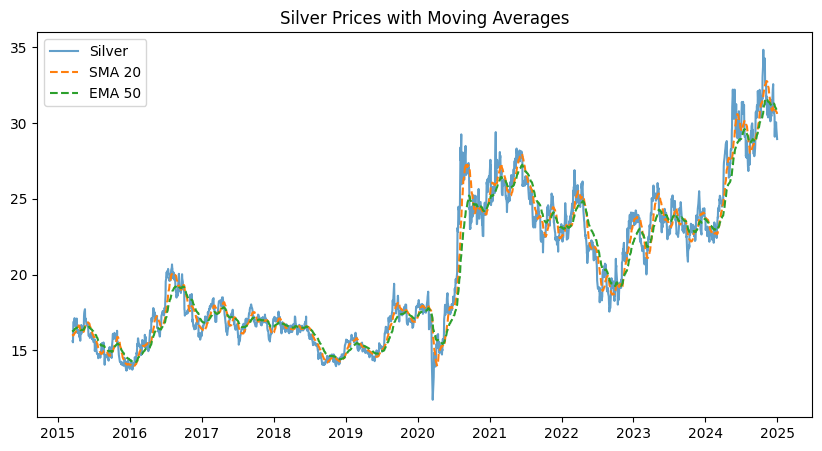

Price,SILVER,RSI,MACD,Signal_Line,SMA_20,EMA_50
Ticker,SI=F,,,,,
Date,,,,,,
2024-12-24,29.974001,42.597238,-0.395949,-0.251606,30.79275,30.978347
2024-12-26,30.047001,43.333040,-0.394179,-0.280120,30.77570,30.941823
2024-12-27,29.655001,40.342567,-0.419571,-0.308010,30.75290,30.891360
2024-12-30,29.106001,36.539343,-0.478478,-0.342104,30.67395,30.821346
2024-12-31,28.940001,35.451066,-0.532420,-0.380167,30.59850,30.747567


In [3]:
# --- 4. Technical Indicators (RSI, MACD, SMA, EMA) ---

# Ensure the 'SILVER' column is a 1-D Series
silver_series = pd.Series(np.ravel(df["SILVER"].values), index=df.index)

# RSI
df["RSI"] = RSIIndicator(close=silver_series, window=14).rsi()

# MACD
macd_obj = MACD(close=silver_series)
df["MACD"] = pd.Series(np.ravel(macd_obj.macd().values), index=df.index)
df["Signal_Line"] = pd.Series(np.ravel(macd_obj.macd_signal().values), index=df.index)

# Moving Averages
df["SMA_20"] = SMAIndicator(close=silver_series, window=20).sma_indicator()
df["EMA_50"] = EMAIndicator(close=silver_series, window=50).ema_indicator()

# Clean up
df.dropna(inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df["SILVER"], label="Silver", alpha=0.7)
plt.plot(df["SMA_20"], label="SMA 20", linestyle="--")
plt.plot(df["EMA_50"], label="EMA 50", linestyle="--")
plt.title("Silver Prices with Moving Averages")
plt.legend()
plt.show()

df.tail()

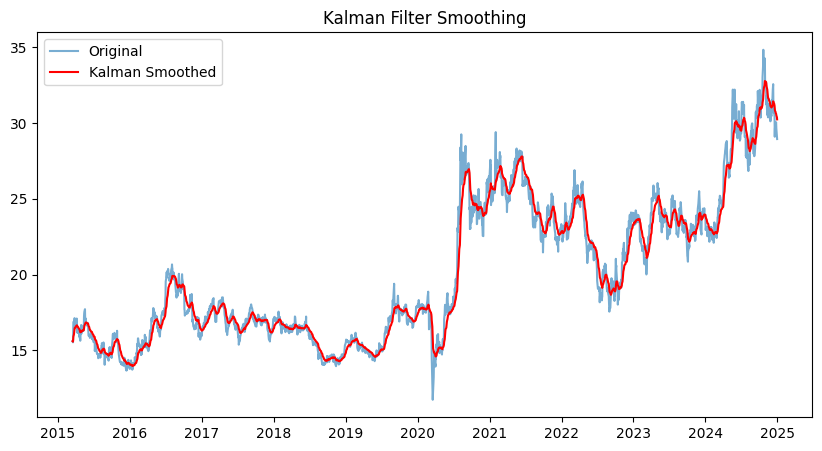

In [4]:
# --- Kalman Filter Smoothing ---
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=df["SILVER"].values[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

state_means, _ = kf.filter(df["SILVER"].values)
df["Kalman_Smoothed"] = state_means

plt.figure(figsize=(10,5))
plt.plot(df["SILVER"], label="Original", alpha=0.6)
plt.plot(df["Kalman_Smoothed"], label="Kalman Smoothed", color='red')
plt.legend()
plt.title("Kalman Filter Smoothing")
plt.show()

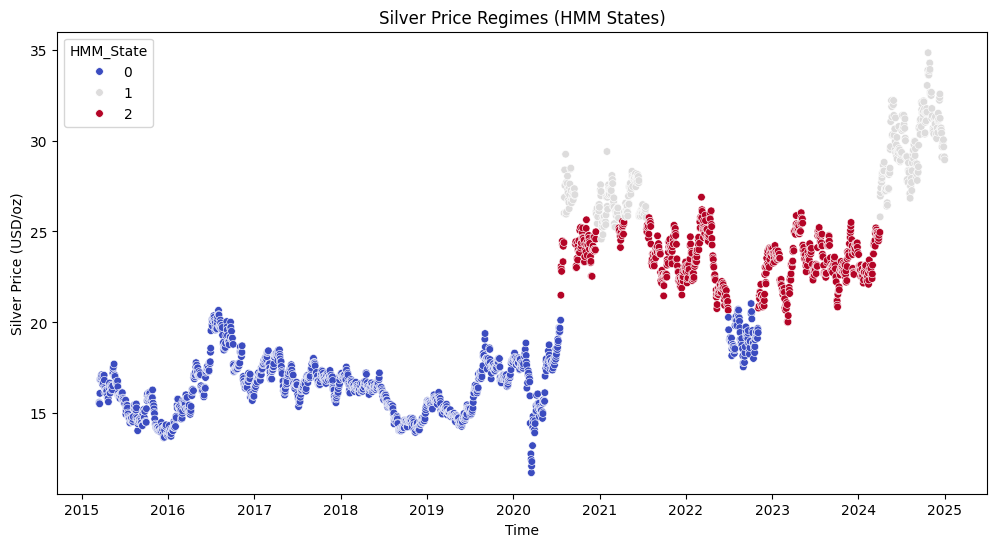

In [5]:
# --- 6. Hidden Markov Model (HMM) ---

# Ensure the silver data is 1-D for fitting and plotting
silver_vals = np.ravel(df["SILVER"].values)

# Fit the model
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=200)
hmm.fit(silver_vals.reshape(-1, 1))
hidden_states = hmm.predict(silver_vals.reshape(-1, 1))

# Store in DataFrame
df["HMM_State"] = hidden_states

# Plot — make sure everything passed to seaborn is 1-D
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=df.index,
    y=np.ravel(df["SILVER"].values),
    hue=df["HMM_State"],
    palette="coolwarm",
    s=30
)
plt.title("Silver Price Regimes (HMM States)")
plt.xlabel("Time")
plt.ylabel("Silver Price (USD/oz)")
plt.show()

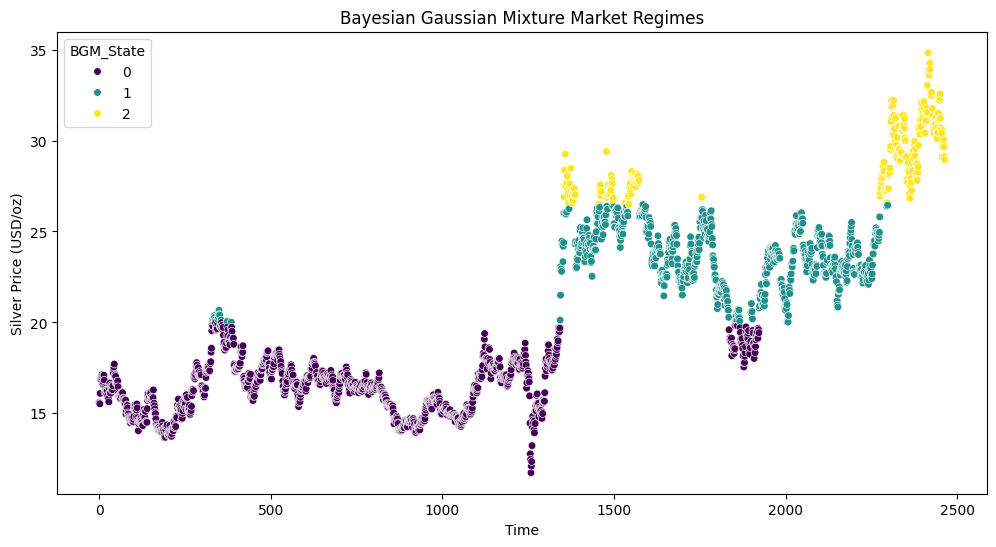

In [6]:
# --- 7. Bayesian Gaussian Mixture (BGM) ---

# Make sure silver prices are strictly 1-D
silver_vals = np.ravel(df["SILVER"].values)

# Fit Bayesian Gaussian Mixture model
bgm = BayesianGaussianMixture(n_components=3, covariance_type="diag", n_init=5)
bgm.fit(silver_vals.reshape(-1, 1))
bgm_states = bgm.predict(silver_vals.reshape(-1, 1))

# Store the states in DataFrame
df["BGM_State"] = bgm_states

# Plot regimes — ensure all arrays are 1-D
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.arange(len(silver_vals)),
    y=silver_vals,
    hue=df["BGM_State"].astype(int),
    palette="viridis",
    s=30
)
plt.title("Bayesian Gaussian Mixture Market Regimes")
plt.xlabel("Time")
plt.ylabel("Silver Price (USD/oz)")
plt.show()

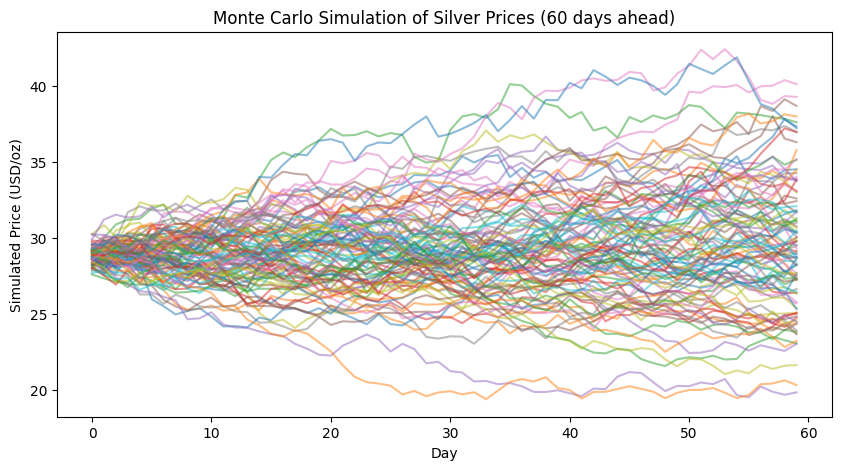

In [7]:
# --- 8. Monte Carlo Simulation for Silver Prices ---

import numpy as np
import matplotlib.pyplot as plt

# Extract and clean silver prices
silver_prices = df["SILVER"].values.flatten()

# Calculate daily log returns
log_returns = np.diff(np.log(silver_prices))
mu = np.mean(log_returns)
sigma = np.std(log_returns)

# Simulation parameters
n_simulations = 100     # number of simulated paths
n_days = 60             # days to simulate

# Initialize matrix for simulations
simulations = np.zeros((n_days, n_simulations))

# Run simulations
for sim in range(n_simulations):
    price_series = [silver_prices[-1]]  # start from last known price
    for day in range(1, n_days + 1):
        # geometric Brownian motion formula
        price = price_series[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        price_series.append(price)
    # Ensure conversion to numpy array for assignment
    simulations[:, sim] = np.array(price_series[1:])

# Plot all simulated paths
plt.figure(figsize=(10, 5))
plt.plot(simulations, alpha=0.5)
plt.title("Monte Carlo Simulation of Silver Prices (60 days ahead)")
plt.xlabel("Day")
plt.ylabel("Simulated Price (USD/oz)")
plt.show()

<Figure size 1000x500 with 0 Axes>

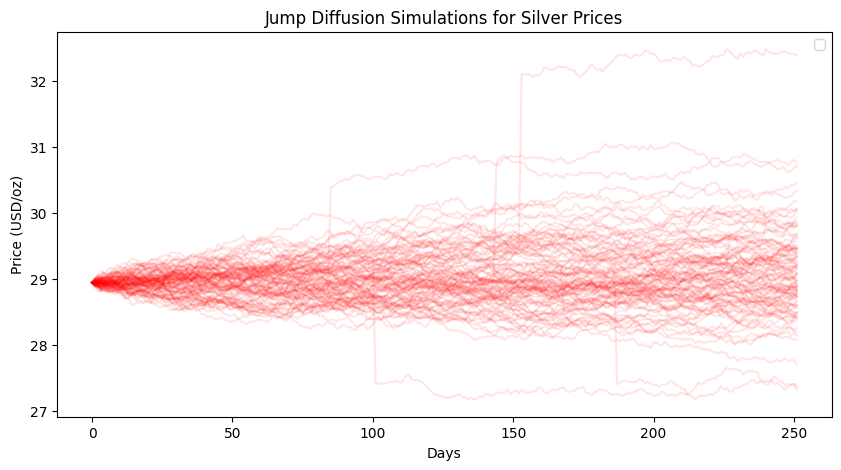

In [8]:
# --- Jump Diffusion Model ---

def jump_diffusion_sim(S0, mu, sigma, lamb, mu_j, sigma_j, T=1, steps=252, n_sims=100):
    dt = T/steps
    prices = np.zeros((steps, n_sims))
    for sim in range(n_sims):
        prices[0, sim] = S0
        for t in range(1, steps):
            N = np.random.poisson(lamb * dt)
            J = np.sum(np.random.normal(mu_j, sigma_j, N))
            drift = (mu - 0.5 * sigma**2) * dt
            diffusion = sigma * np.sqrt(dt) * np.random.normal()
            prices[t, sim] = prices[t-1, sim] * np.exp(drift + diffusion + J)
    return prices

mu = df["SILVER"].pct_change().mean()
sigma = df["SILVER"].pct_change().std()
S0 = df["SILVER"].iloc[-1]
jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05)
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
plt.plot(jd_prices, alpha=0.1, color='red')
plt.title("Jump Diffusion Simulations for Silver Prices")
plt.xlabel("Days")
plt.ylabel("Price (USD/oz)")
plt.legend()
plt.show()

In [9]:
# --- NLTK Sentiment Analysis ---
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

headlines = [
    "Silver prices rally on industrial demand growth",
    "Concerns rise over declining silver demand from jewelry",
    "Solar panel demand boosts silver prices",
]

def get_nltk_sentiment(texts):
    sentiments = []
    for text in texts:
        scores = sia.polarity_scores(text)
        compound = scores['compound']
        
        # Classify based on compound score
        if compound >= 0.05:
            sentiment = "Positive"
        elif compound <= -0.05:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        sentiments.append(sentiment)
    return sentiments

sentiments = get_nltk_sentiment(headlines)
for h, s in zip(headlines, sentiments):
    print(f"{h} → {s}")

Silver prices rally on industrial demand growth → Positive
Concerns rise over declining silver demand from jewelry → Negative
Solar panel demand boosts silver prices → Positive


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0092 - val_loss: 0.0021
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0012 - val_loss: 9.4817e-04
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss:

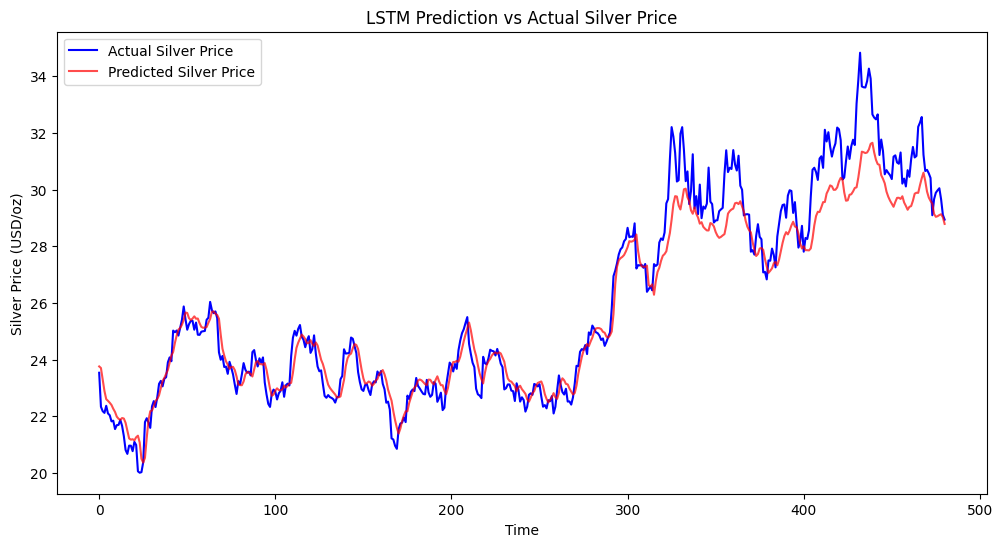

RMSE: 0.9086


In [10]:
# --- 9. LSTM Training and Silver Price Prediction ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- Prepare Data ---

# Select numerical columns (excluding date if any)
features = df.select_dtypes(include=[np.number]).copy()

# Choose your target column here
target_col = "SILVER"  # <-- change to "SILVER" later if needed

if target_col not in features.columns:
    raise ValueError(f"{target_col} column not found in dataframe. Available columns: {list(features.columns)}")

# Fill NaN values
features = features.fillna(method='ffill').fillna(method='bfill')

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, features.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Split into train/test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build LSTM Model ---

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# Inverse transform predictions & actuals to original scale
scaler_for_target = MinMaxScaler()
scaler_for_target.fit(features[[target_col]])
y_test_rescaled = scaler_for_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_for_target.inverse_transform(y_pred)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Silver Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Silver Price', color='red', alpha=0.7)
plt.title("LSTM Prediction vs Actual Silver Price")
plt.xlabel("Time")
plt.ylabel("Silver Price (USD/oz)")
plt.legend()
plt.show()

# --- RMSE ---
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.4f}")
from sklearn.metrics import r2_score

# Calculate R²
#r2 = r2_score(y_test, predicted_prices)
#print(f"R² Score: {r2:.4f}")

In [11]:
# --- Model Evaluation Metrics ---

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Try to detect prediction variable
try:
    y_pred_eval = predicted_prices
except NameError:
    try:
        y_pred_eval = predictions
    except NameError:
        try:
            y_pred_eval = y_pred
        except NameError:
            raise NameError("Couldn't find prediction variable. Make sure your LSTM cell outputs predictions.")

# Ensure both y_test and predictions are 1D arrays
y_test = np.array(y_test).flatten()
y_pred_eval = np.array(y_pred_eval).flatten()

# Calculate metrics
r2 = r2_score(y_test, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_eval))
mae = mean_absolute_error(y_test, y_pred_eval)

# Print results
print("📊 Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

📊 Model Performance Metrics:
R² Score: 0.9331
RMSE: 0.0393
MAE: 0.0280


In [12]:
# --- Save Future Predictions to CSV ---

import pandas as pd
from datetime import datetime, timedelta

# Get the last date from the original data
last_date = df.index[-1]

# Generate future dates for predictions (same number as test predictions)
future_dates = [last_date + timedelta(days=i) for i in range(1, len(y_pred_rescaled) + 1)]

# Create a DataFrame with future predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': y_pred_rescaled.flatten()
})

# Save to CSV
output_filename = f'silver_future_predictions_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
future_predictions_df.to_csv(output_filename, index=False)
print(f"✅ Future predictions saved to: {output_filename}")
print(f"📊 Total predictions: {len(future_predictions_df)}")
print(f"📈 Price range: ${future_predictions_df['Predicted_Price'].min():.2f} - ${future_predictions_df['Predicted_Price'].max():.2f}")
print("\nFirst 5 predictions:")
print(future_predictions_df.head())


✅ Future predictions saved to: silver_future_predictions_20251111_202416.csv
📊 Total predictions: 481
📈 Price range: $20.36 - $31.65

First 5 predictions:
        Date  Predicted_Price
0 2025-01-01        23.756844
1 2025-01-02        23.701584
2 2025-01-03        23.286646
3 2025-01-04        22.887920
4 2025-01-05        22.602179
